# Correlations for periodic and aperiodic signals

By default, `acorr` and `xcorr`
 quickly calculate good estimates for situations where the longest lag of interest is short compared to the signal length. It also provides convenient options to normalise as correlation or covariance. However, there are situations where the subtle differences between different methods to calculate correlations matter. These are discussed below.

In [1]:
import numpy as np
# set the plotting backend
import matplotlib
matplotlib.use('nbagg') # change according to your needs: agg, tkagg, ...
import matplotlib.pyplot as plt
plt.ion()

In [3]:
import scorr

ModuleNotFoundError: No module named 'corr2'

## Generate a test signal

In [3]:
def timesteps(steps,tmax):
    dt = tmax / float(steps)
    t  = np.arange(0,tmax,dt)
    return t, dt

# scorr should be much faster than np.correlate for large numbers of steps (e.g. 10**6)
steps = 10**5
tmax  = 10 * np.pi
t, dt = timesteps(steps, tmax)
x     = np.sin(t)

<IPython.core.display.Javascript object>


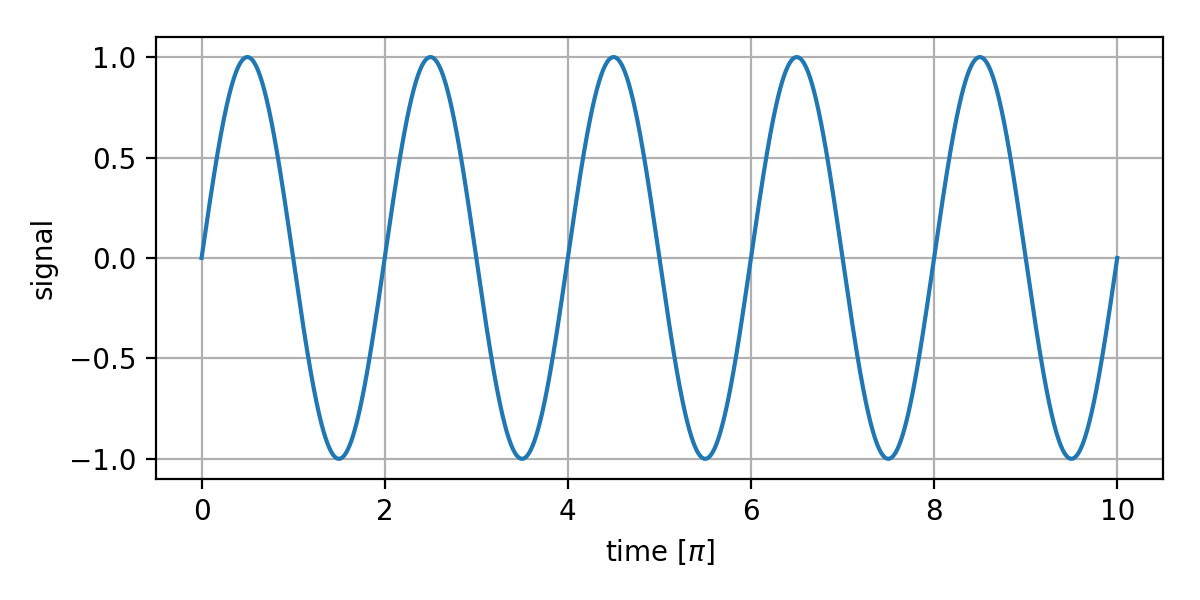

In [4]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(t / np.pi, x)
ax.set_xlabel(r'time [$\pi$]')
ax.set_ylabel('signal')
ax.grid(True)
fig.tight_layout()

## Analyse as a finite, aperiodic signal
Here we assume that the signal is zero everywhere outside of the interval [0, tmax]. Hence we pad with as many zeros as data points to demix the causal and anti-causal part.

In [5]:
%%time
r_fft = scorr.acorr(x, nfft='demix')

CPU times: user 50.9 ms, sys: 15.6 ms, total: 66.6 ms
Wall time: 66.6 ms


In [6]:
%%time
mx = np.mean(x)
r_np = (np.correlate(x - mx, x - mx, 'full') / len(x) / np.var(x))
# we need to subtract the mean and normalise by the number of samples
# and the signal's variance to have a "true" autocorrelation normalised to
# one at lag zero.

CPU times: user 5.26 s, sys: 43.8 ms, total: 5.31 s
Wall time: 5.35 s


<IPython.core.display.Javascript object>


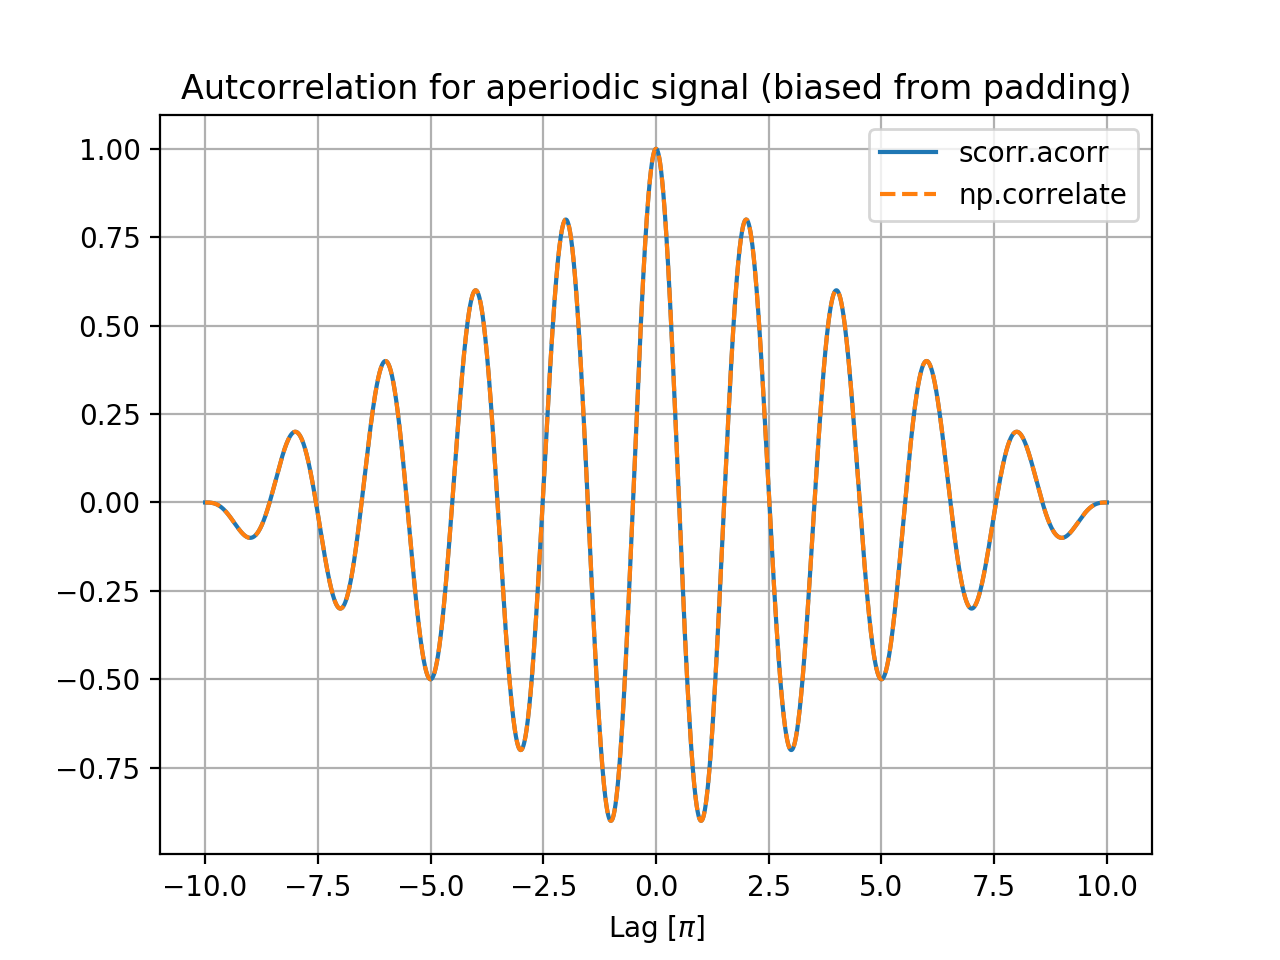

In [7]:
fig, ax = plt.subplots()
ax.set_title('Autcorrelation for aperiodic signal (biased from padding)')
lag = np.arange(-tmax, tmax+dt, dt) / np.pi # centered to match np.correlate
ax.plot(lag, scorr.xcorrshift(r_fft), label='scorr.acorr')
ax.plot(lag[:len(r_np)], r_np, '--', label='np.correlate')
ax.grid(True)
ax.legend()
ax.set_xlabel('Lag [$\pi$]')

## Analyse as a periodic signal

Here we assume that the signal is repeated forever. Accordingly, we use the exact length of the repeated signal for the FFT.

In [8]:
# Keep the number of steps low because a brute-force calculation is coming below!
# tmax must be an even multiple of pi to obtain a periodic signal!
steps = 10**3
tmax  = 10 * np.pi
t, dt = timesteps(steps, tmax)
x     = np.sin(t)

In [9]:
%%time
# calculate the auto-correlation using the true analytical function
r_brutforce = []
for i in range(0,steps):
    r_brutforce.append(
        np.mean(np.sin(t) * np.sin((t + dt*i)))
    )
r_bruteforce = np.array(r_brutforce) / np.var(x)

CPU times: user 71.3 ms, sys: 1.09 ms, total: 72.4 ms
Wall time: 74.6 ms


In [10]:
%%time
r_fft = scorr.acorr(x, nfft='len', subtract_mean=False)
print len(r_fft)

1000
CPU times: user 1.32 ms, sys: 981 µs, total: 2.3 ms
Wall time: 1.47 ms


<IPython.core.display.Javascript object>


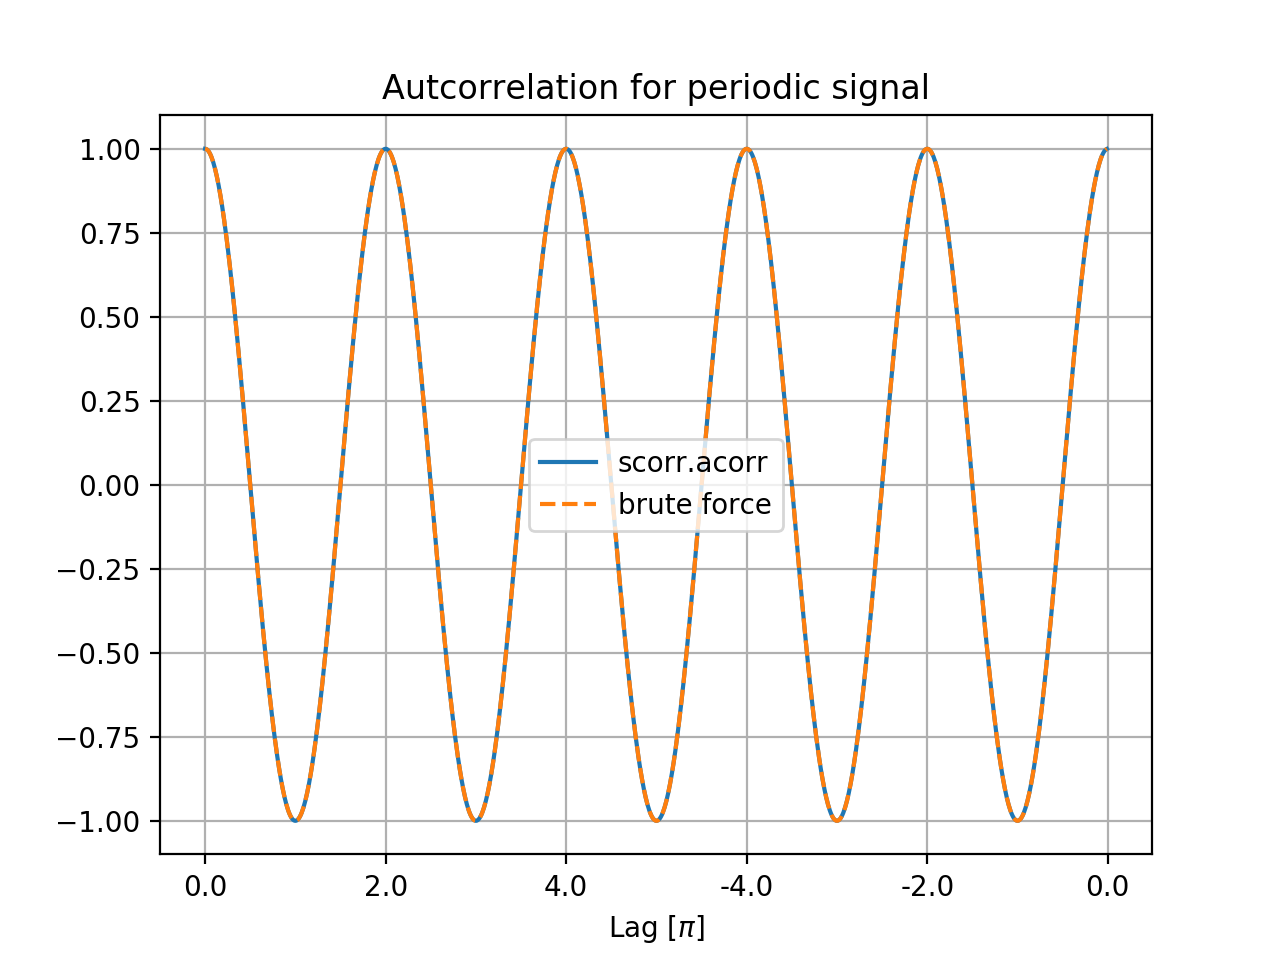

In [11]:
fig, ax = plt.subplots()
ax.set_title('Autcorrelation for periodic signal')
ax.plot(r_fft, label='scorr.acorr')
ax.plot(r_bruteforce, '--', label='brute force')
ax.grid(True)
ax.legend()
# we left r uncentered - here centering would look the same
# but one could argue that not centering makes the periodicity even more 
# obvious due to the discontinous lag in the center
ax.xaxis.set_major_formatter(
    matplotlib.ticker.FuncFormatter(
        lambda v,p: np.round((v - (v >= len(t)/2) * len(t)) * dt / np.pi)
    )
)
ax.set_xlabel('Lag [$\pi$]')

## Padding bias

The aperiodic analysis above assumes that the "unobserved" signal is zero. This forced the autocorrelation to converge to zero for long lags. If we assume that the signal continues with identical statistics, we can try to correct this bias without assuming periodicity.

In [12]:
# Keep the number of steps low because a brute-force calculation is coming below!
# tmax must be an even multiple of pi to obtain a periodic signal!
steps = 10**3
tmax  = 10 * np.pi
t, dt = timesteps(steps, tmax)
x     = np.sin(t)

In [13]:
r_unbiased = scorr.acorr(x, nfft='demix', debias=True)

This is equivalent to the following  calculation:

In [14]:
r_bruteforce = np.zeros(2 * steps)
r_bruteforce[0] = 1
vx = np.var(x)
for l in range(1,steps):
    r_bruteforce[l]  = np.mean(x[:-l] * x[l:]) / vx
    r_bruteforce[-l] = np.mean(x[:-l] * x[l:]) / vx

The resulting correlation is only based on actual observations does not assume periodicity or zeros outside the observed interval. Of course using it with an oscillation leads to artefacts when the lag is within one period of the total signal length. For a more useful application, see the examples in `pandas_groups_and_bias.ipynb`.

<IPython.core.display.Javascript object>


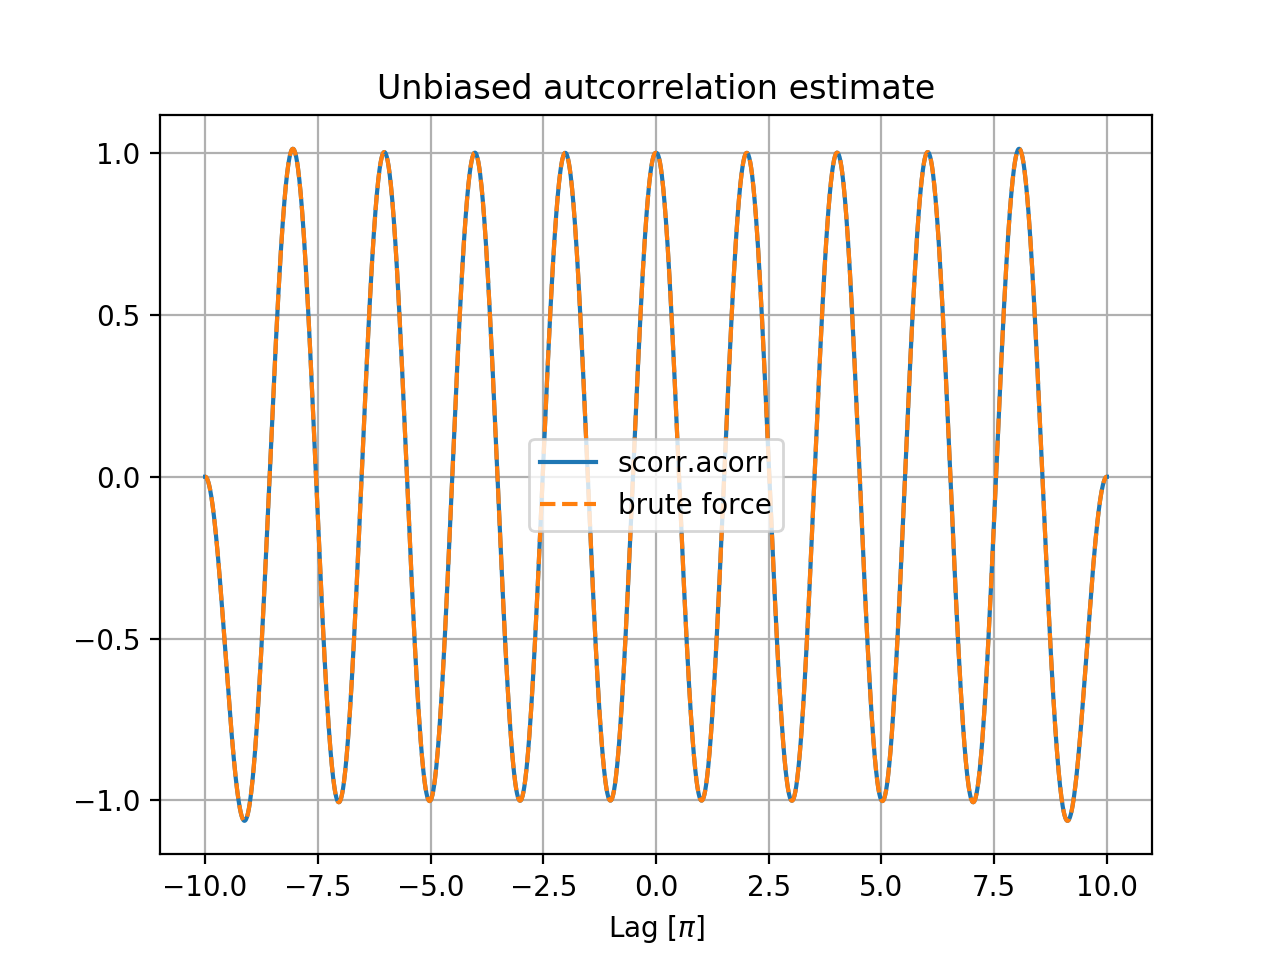

In [15]:
fig, ax = plt.subplots()
ax.set_title('Unbiased autcorrelation estimate')
lag = np.arange(-tmax, tmax+dt, dt) / np.pi # centered to match np.correlate
ax.plot(lag, scorr.xcorrshift(r_unbiased), label='scorr.acorr')
ax.plot(lag, scorr.xcorrshift(r_bruteforce), '--', label='brute force')
ax.grid(True)
ax.legend()
ax.set_xlabel('Lag [$\pi$]')